In [8]:
import os
from typing import TypedDict
from langgraph.graph import StateGraph, START,END
from langchain_community.document_loaders import PyPDFLoader
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [9]:
load_dotenv()
nvidia_api_key = os.getenv("NVIDIA_API_KEY")

In [10]:
loader = PyPDFLoader('Design and Analysis of Algorithm Note.pdf')
docs = loader.load()

In [11]:
len(docs)

230

In [12]:
docs[0].page_content

'1 | P a g e  \nClass Note \n202045601 \nDesign and Analysis of \nAlgorithms  \nSemester V'

In [13]:
final_docs = []
for i in range(0, 230):
    final_docs.append(docs[i].page_content)

In [14]:
len(final_docs)

230

In [15]:
final_docs = str(final_docs)

In [16]:
print(final_docs)

['1 | P a g e  \nClass Note \n202045601 \nDesign and Analysis of \nAlgorithms  \nSemester V', '2 | P a g e  \n \n \n \nCHAPTER – 1 What is \nAlgorithm? and Basics', '3 | P a g e  \n1.1 Algorithm \nAn algorithm is a set of steps of operations to solve a problem  performing calculation, data \nprocessing, and automated reasoning tasks. An algorithm is an efficient method that can be \nexpressed within a finite amount of time and space. \n \n \nAn algorithm is the best way to represent the solution of a particular problem in a very simple \nand efficient way. If we have an algorithm for a specific problem, then we can implement it \nin any programming language, meaning that the algorithm is independent from any \nprogramming languages. \nAlgorithm is like procedure which does somet hing. For example, preparing the dish of food, \nsome experiment done by the student in physics. Each procedure needs some input and \nproduce output.  \nAlgorithms can be expressed as natural languages , progr

In [17]:
length_function = len
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=500, 
    chunk_overlap=100,
    length_function=length_function,
)
text = final_docs
splits = splitter.split_text(text)

In [18]:
len(splits)

563

In [19]:
print(splits[0])

['1 | P a g e  \nClass Note \n202045601 \nDesign and Analysis of \nAlgorithms  \nSemester V', '2 | P a g e  \n \n \n \nCHAPTER – 1 What is \nAlgorithm? and Basics', '3 | P a g e  \n1.1 Algorithm \nAn algorithm is a set of steps of operations to solve a problem  performing calculation, data \nprocessing, and automated reasoning tasks. An algorithm is an efficient method that can be \nexpressed within a finite amount of time and space. \n \n \nAn algorithm is the best way to represent the solution


In [20]:
embeddings = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    api_key=nvidia_api_key
)

vector_store = Chroma.from_texts(
    embedding = embeddings,
    texts = splits,
    persist_directory='DAA_notes_chroma_db',
    collection_name='sample'
)

In [21]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 30})

In [22]:
retriever.invoke('knapsack problem')

[Document(metadata={}, page_content='example, the weight of the  container is 20 kg. We have to select the items in such a way \\nthat the sum of the weight of items should be either smaller than or equal to the weight of the \\ncontainer, and the profit should be maximum. \\nThere are two types of knapsack problems: \\no 0/1 knapsack problem \\no Fractional knapsack problem \\nWhat is the 0/1 knapsack problem? \\nThe 0/1 knapsack problem means that the items are either completely or no items are filled in \\na knapsack. For example, we'),
 Document(metadata={}, page_content='example, the weight of the  container is 20 kg. We have to select the items in such a way \\nthat the sum of the weight of items should be either smaller than or equal to the weight of the \\ncontainer, and the profit should be maximum. \\nThere are two types of knapsack problems: \\no 0/1 knapsack problem \\no Fractional knapsack problem \\nWhat is the 0/1 knapsack problem? \\nThe 0/1 knapsack problem means that 

In [23]:
class Agentstste(TypedDict):
    question : str
    retrieved_docs : str
    grade_response :str
    answer : str
    hallucination_response : str
    check_answer_response : str

In [24]:
llm  = ChatNVIDIA(model="meta/llama3-70b-instruct")
parser = StrOutputParser()

RETRIEVE DOCUMENTS NODE

In [25]:
def retrive_docs(state : Agentstste):
    print('in retrive node\n')
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 30})
    docs = retriever.invoke(state["question"])

    state["retrived_docs"] = "\n\n".join(doc.page_content for doc in docs)
    return state

retrive_docs({'question':'making change problem'})

in retrive node



{'question': 'making change problem',
 'retrived_docs': "Making change problem \\n \\nWe are given the coins of different denominations and a value X. We need to find the \\nminimum number of coins required to make value X. We have infinite supply of each coin.  \\n \\nNow, see the following making change problem using greedy approach: \\nDenom[] = { 1, 5, 6, 9 } \\nX = 11 \\nSolution using greedy approach gives the answer = { 9, 1, 1 } which is not optimal. \\n \\nHere, it shows that solution does not exist even if solution is found.  \\nDenom[] ={ 4, 10, 25 }\n\nMaking change problem \\n \\nWe are given the coins of different denominations and a value X. We need to find the \\nminimum number of coins required to make value X. We have infinite supply of each coin.  \\n \\nNow, see the following making change problem using greedy approach: \\nDenom[] = { 1, 5, 6, 9 } \\nX = 11 \\nSolution using greedy approach gives the answer = { 9, 1, 1 } which is not optimal. \\n \\nHere, it shows t

In [26]:
def display(state : Agentstste):
    print(state['question'])


display({'question':'making change problem'})

making change problem


In [27]:
def grade(state : Agentstste):

    print('\ngrade node')
    prompt = PromptTemplate(
    template="""
        You are a assistance that grade the retrive docs either yes or no.

        User question
        {question}

        Retrieved docs:
        {retrieved_docs}

        Analyze that retrieved docs are relevant to the question or not.
        if not relevant give in reponse only no
        ir yes give in reponse only yes
        """,
    input_variables = ['question', 'retrieved_docs']
    )

    chain = prompt | llm | parser
    state['grade_response'] =chain.invoke({'question':state['question'], 'retrieved_docs': state['retrieved_docs']})
    return state

In [28]:
def generate_answer(state : Agentstste):
    print('\ngenerate_answer node')
    prompt = PromptTemplate(
    template="""
        You are a assistance that generates answer of user question with the help of context that is provided to you.

        User question
        {question}

        context:
        {retrieved_docs}

        """,
    input_variables = ['question', 'retrieved_docs']
    )

    chain = prompt | llm | parser
    state['answer'] = chain.invoke({'question':state['question'], 'retrieved_docs': state['retrieved_docs']})
    return state

In [29]:
def check_hallucination(state : Agentstste):
    print('check_hallucination node')
    prompt = PromptTemplate(
    template="""
        You are a assistance that checks any hallucination in the generated answer.

        generated answer:
        {answer}

        - if there is hallucination in answer return only yes
        - if there is no hallucination in answer return only no

        """,
    input_variables = ['answer']
    )

    chain = prompt | llm | parser
    state['hallucination_response'] = chain.invoke({'answer':state['answer']})
    return state

In [30]:
def chck_answers_question(state : Agentstste):
    print('chck_answers_question node')
    prompt = PromptTemplate(
    template="""
        You are a assistance that checks generated answer is appropriate according to question.

        generated answer:
        {answer}

        question:
        {question}

        - if answer is appropriate then return only yes
        - if answer is not appropriate then return only no

        """,
    input_variables = ['answer','question']
    )

    chain = prompt | llm | parser
    state['check_answer_response'] = chain.invoke({'answer':state['answer'], 'question':state['question']})
    return state

In [31]:
def rewrite_question(state : Agentstste):
    print('rewrite_question noe')
    prompt = PromptTemplate(
    template="""
        You are a assistance that rewrite the user's question to improve the results.

        question:
        {question}

        """,
    input_variables = ['question']
    )

    chain = prompt | llm | parser
    state['question'] = chain.invoke({'question':state['question']})
    return state

In [32]:
graph = StateGraph(Agentstste)

graph.add_node("retrive_docs",retrive_docs)
graph.add_node("grade",grade)
graph.add_node("generate_answer",generate_answer)
graph.add_node("check_hallucination",check_hallucination)
graph.add_node("chck_answers_question",chck_answers_question)
graph.add_node("rewrite_question",rewrite_question)

graph.add_edge(START, 'retrive_docs')
graph.add_edge('retrive_docs','grade')
graph.add_conditional_edges(
    "grade", #source node name
    grade, #path(function name)

    #path map
    {   
        # Edge : node
        "yes" : "generate_answer",
        "no" : "rewrite_question"
    }
)
graph.add_edge('generate_answer','check_hallucination')
graph.add_conditional_edges(
    "check_hallucination", #source node name
    check_hallucination, #path(function name)

    #path map
    {   
        # Edge : node
        "yes" : "generate_answer",
        "no" : "chck_answers_question"
    }
)
graph.add_conditional_edges(
    "chck_answers_question", #source node name
    chck_answers_question, #path(function name)

    #path map
    {   
        # Edge : node
        "yes" : END,
        "no" : "rewrite_question"
    }
)
graph.add_edge('rewrite_question','retrive_docs')

app = graph.compile()

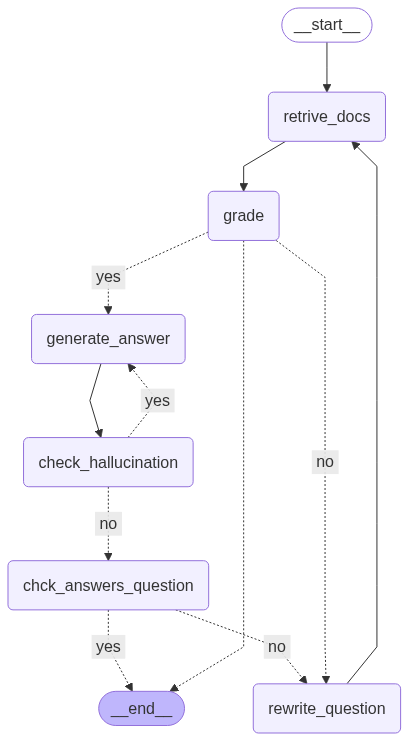

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
initial_state1 = Agentstste(question='types of making change problem')
print(app.invoke(initial_state1))

in retrive node


grade node


KeyError: 'retrieved_docs'

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

In [35]:
search  = DuckDuckGoSearchRun()
search.invoke('making change problem')

'[Better Approach 1] Using Top-Down DP (Memoization) - O(sum*n) t ime and O(sum*n) space. 1. Optimal Substructure: Number of ways to make sum at index i, i.e., count(i, sum, coins), depends on the optimal solutions of the subproblems count(i, sum-coins[i-1], coins) , and count(i-1, sum, coins). By adding these optimal substructures, we can efficiently calculate the number of ways to make target ... [Naive Approach ] Using Recursion - O(n^sum) Time and O(sum) Space. This problem is a variation of the problem Coin Change Problem.Here instead of finding the total number of possible solutions, we need to find the solution with the minimum number of coins.. The idea is to find the minimum number of coins required to reach the target sum by trying each coin denomination in the coins[] array. The Coin Change Problem involves finding the number of ways to make change for a given amount using a set of coin denominations. Example: Consider an integer array coins[] representing different coin den

In [36]:
retriever.invoke('dynamic programing')

[Document(metadata={}, page_content="\\n \\nCHAPTER – 7  Dynamic \\nProgramming', '137 | P a g e  \\n7.1 Introduction to Dynamic Programming \\nDynamic Programming is mainly an optimization over plain  recursion. Wherever we see a \\nrecursive solution that has repeated calls for same inputs, we can optimize it using Dynamic \\nProgramming. The idea is to simply store the results of subproblems, so that we do not have to \\nre-compute them when needed later. This simple optimization reduces time complexities from \\nexponential to"),
 Document(metadata={}, page_content="\\n \\nCHAPTER – 7  Dynamic \\nProgramming', '137 | P a g e  \\n7.1 Introduction to Dynamic Programming \\nDynamic Programming is mainly an optimization over plain  recursion. Wherever we see a \\nrecursive solution that has repeated calls for same inputs, we can optimize it using Dynamic \\nProgramming. The idea is to simply store the results of subproblems, so that we do not have to \\nre-compute them when needed late

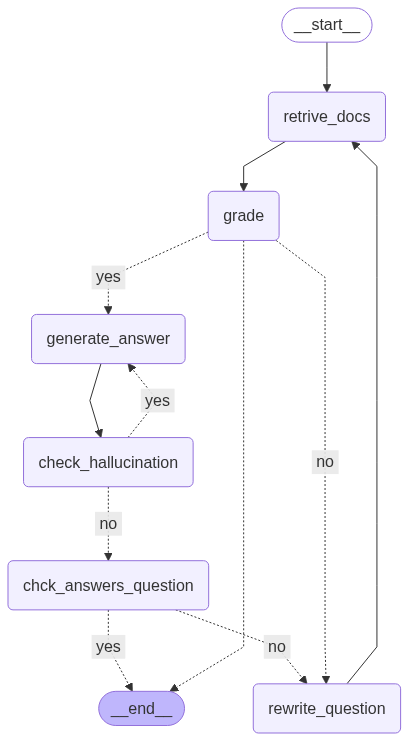

In [4]:
import os
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()
nvidia_api_key = os.getenv("NVIDIA_API_KEY")

llm = ChatNVIDIA(model="meta/llama3-70b-instruct")
parser = StrOutputParser()

embeddings = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    api_key=nvidia_api_key
)

vector_store = Chroma(
    persist_directory='DAA_notes_chroma_db',
    embedding_function=embeddings,
    collection_name='sample'
)

class Agentstste(TypedDict):
    question: str
    retrieved_docs: str
    grade_response: str
    answer: str
    hallucination_response: str
    check_answer_response: str

def retrive_docs(state: Agentstste):
    print('📥 Node: Retrieve Docs')
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 30})
    docs = retriever.invoke(state["question"])
    state["retrieved_docs"] = "\n\n".join(doc.page_content for doc in docs)
    return state

def grade(state: Agentstste):
    print('\n🧠 Node: Grade Context')
    prompt = PromptTemplate(
        template="""You are a DAA expert. Decide if the retrieved context is relevant to the question.

        Question:
        {question}

        Context:
        {retrieved_docs}

        Respond ONLY with "yes" or "no".
        """, input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'question': state['question'], 'retrieved_docs': state['retrieved_docs']})
    state['grade_response'] = result
    return state

def grade_condition(state: Agentstste) -> str:
    return state["grade_response"]

def generate_answer(state: Agentstste):
    print('\n Node: Generate Answer')
    prompt = PromptTemplate(
        template="""You are a DAA professor. Use only the given context to answer the question.

        Question:
        {question}

        Lecture Notes Context:
        {retrieved_docs}

        Write clearly using examples, formulas, and structured explanation.
        """, input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    state['answer'] = chain.invoke({'question': state['question'], 'retrieved_docs': state['retrieved_docs']})
    return state

def check_hallucination(state: Agentstste):
    print('🔍 Node: Check Hallucination')
    prompt = PromptTemplate(
        template="""You are a DAA professor verifying if the answer is based only on the notes.

        Answer:
        {answer}

        Respond ONLY with "yes" (hallucinated) or "no" (faithful).
        """, input_variables=['answer']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'answer': state['answer']})
    state['hallucination_response'] = result
    return state

def hallucination_condition(state: Agentstste) -> str:
    return state["hallucination_response"]

def chck_answers_question(state: Agentstste):
    print('✅ Node: Check Answer Relevance')
    prompt = PromptTemplate(
        template="""Does the answer fully address the question in the DAA domain?

        Question:
        {question}

        Answer:
        {answer}

        Respond ONLY with "yes" or "no".
        """, input_variables=['answer', 'question']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'answer': state['answer'], 'question': state['question']})
    state['check_answer_response'] = result
    return state

def check_answer_condition(state: Agentstste) -> str:
    return state["check_answer_response"]

def rewrite_question(state: Agentstste):
    print('🔁 Node: Rewrite Question')
    prompt = PromptTemplate(
        template="""Rewrite the following DAA question for clarity and better context matching:

Original:
{question}
""", input_variables=['question']
    )
    chain = prompt | llm | parser
    state['question'] = chain.invoke({'question': state['question']})
    return state

# Build LangGraph
graph = StateGraph(Agentstste)
graph.add_node("retrive_docs", retrive_docs)
graph.add_node("grade", grade)
graph.add_node("generate_answer", generate_answer)
graph.add_node("check_hallucination", check_hallucination)
graph.add_node("chck_answers_question", chck_answers_question)
graph.add_node("rewrite_question", rewrite_question)

graph.add_edge(START, 'retrive_docs')
graph.add_edge('retrive_docs', 'grade')
graph.add_conditional_edges("grade", grade_condition, {
    "yes": "generate_answer",
    "no": "rewrite_question"
})
graph.add_edge('generate_answer', 'check_hallucination')
graph.add_conditional_edges("check_hallucination", hallucination_condition, {
    "yes": "generate_answer",
    "no": "chck_answers_question"
})
graph.add_conditional_edges("chck_answers_question", check_answer_condition, {
    "yes": END,
    "no": "rewrite_question"
})
graph.add_edge("rewrite_question", "retrive_docs")

# Run
app = graph.compile()
# initial_state1 = Agentstste(question='string matching')
# response = app.invoke(initial_state1)

# print("\n🔎 Final Question:", response['question'])
# print("\n Retrieved docs:",response['retrieved_docs'])
# print("📘 Final Answer:\n", response['answer'])

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
